Copyright 2025 Joe Worsham

In [1]:
# obligatory reload content dynamically
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow_dynamics as tfd

In [3]:
import itertools
import math
import numpy as np
import tensorflow as tf

In [4]:
from collections import namedtuple
from matplotlib import pyplot as plt
from tqdm import tqdm

In [5]:
tf.keras.backend.set_floatx('float64')

# XOR Problem

In [11]:
x = tf.constant([-1., 1.], dtype=tf.float64)[:, None]
y = tf.constant([1., -1.], dtype=tf.float64)[:, None]

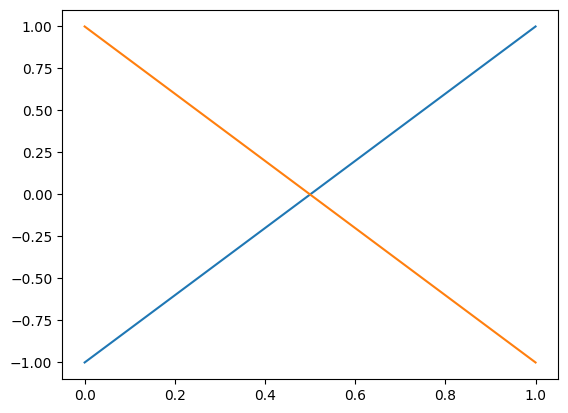

In [12]:
plt.plot([0., 1.], [x[0, 0], y[0, 0]])
plt.plot([0., 1.], [x[1, 0], y[1, 0]])

In [13]:
class NodeClassifier(tf.keras.Model):
    def __init__(self, node):
        super().__init__()
        self._node = node
        self._linear_transform = tfd.models.layers.LinearTransform(1)
        
    def call(self, x):
        x = self._node(x)
        return self._linear_transform(x)

In [49]:
def run_experiment(dx_dt, continuous_loss, encoder, decoder, method, options, use_adjoint, adjoint_options, epochs=200, lr=1e-3):
    # build the NODE to test
    t_0 = tf.zeros([1,], dtype=tf.float64)
    t_f = tf.ones([1,], dtype=tf.float64)
    time_range = tf.linspace(t_0, t_f, 32)
    time_range = tf.transpose(time_range, [1, 0])  # [1, 32]
    node = tfd.models.node.BaseNODE(dx_dt=dx_dt, continuous_loss=continuous_loss,
                                    encoder=encoder, decoder=decoder,
                                    t_eval=time_range,
                                    method=method, options=options, use_adjoint=use_adjoint,
                                    adjoint_options=adjoint_options)
    
    # touch to initialize weights
    y_hat = node(x)
    
    # train for specified epochs
    losses = []
    mse = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    for i in tqdm(range(epochs)):
        with tf.GradientTape() as tape:
            y_hat = node(x)
            y_f_hat = y_hat[:, -1, :]
            loss = mse(y, y_f_hat)
        grads = tape.gradient(loss, node.trainable_variables)
        optimizer.apply_gradients(zip(grads, node.trainable_variables))
        losses.append(loss)
        
    return node, losses

In [34]:
dp5_options = dict(rtol=1e-3, atol=1e-4)
rk4_options = dict(h=tf.constant(1/32, dtype=tf.float64))
dp5_adjoint_options = dict(rtol=1e-12, atol=1e-12)

# Standard NODE

In [35]:
node = tfd.models.layers.AutonomousDxDtMLP(1)
encoder = None
decoder = None
model, losses = run_experiment(node, encoder, decoder,
                               "rk4", rk4_options,
                               True, rk4_options,
                               epochs=100, lr=1e-3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:04<00:00,  3.65s/it]


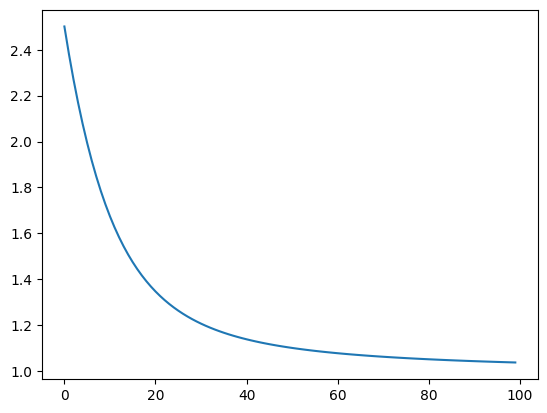

In [36]:
plt.plot(losses)

In [38]:
out_x = model(x)
out_x.shape

TensorShape([2, 32, 1])

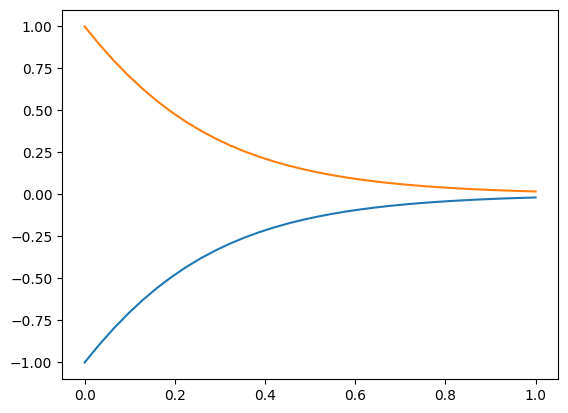

In [39]:
t_eval = np.linspace(0, 1, out_x.shape[1])
ax_2d = plt.figure().add_subplot()
for i in range(2):
    ax_2d.plot(t_eval, out_x[i, :, 0])
plt.show()

# SONODE with Terminal Loss Only

In [124]:
sonode = tfd.models.layers.Autonomous2ndOrderDxDtMLP(1)
encoder = tfd.models.layers.ZeroAugmenter(1, 1)
decoder = tfd.models.layers.Truncate(1)
model, losses = run_experiment(sonode, None, encoder, decoder,
                               "rk4", rk4_options,
                               True, rk4_options,
                               epochs=100, lr=1e-2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:42<00:00,  4.02s/it]


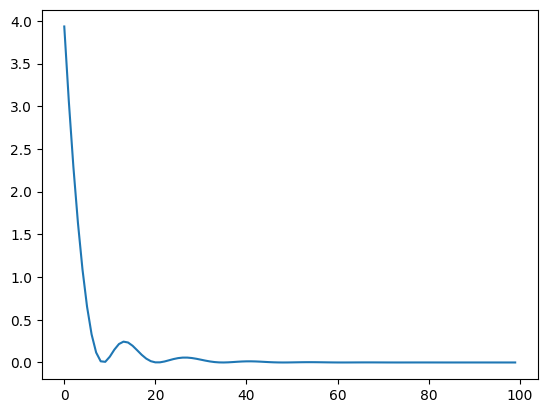

In [125]:
plt.plot(losses)

In [128]:
out_x = model(x, decode=False)
out_x.shape

TensorShape([2, 32, 2])

In [129]:
res = 30
x_c = np.linspace(-1.5, 1.5, res)
x_dot_c = np.linspace(-6., 6., res)
X, Y = np.meshgrid(x_c, x_dot_c)
coords = tf.concat([tf.stack([[X[x, y], Y[x, y]] for y in range(res)], axis=0) for x in range(res)], axis=0)
coords = tf.cast(coords, tf.float64)
coords.shape

TensorShape([900, 2])

In [130]:
dx_dt = sonode(None, coords)
dx_dt.shape

TensorShape([900, 2])

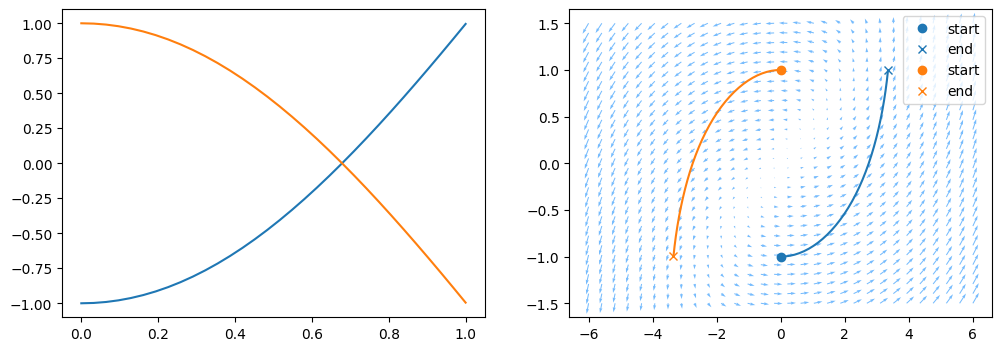

In [131]:
ax_1 = 1
ax_2 = 0
t_eval = np.linspace(0, 1, out_x.shape[1])
fig, (ax_1d, ax_2d) = plt.subplots(1, 2, figsize=(12,4))
ax_2d.quiver(coords[:, ax_1], coords[:, ax_2], dx_dt[:, ax_1], dx_dt[:, ax_2], color="xkcd:sky blue")
for i in range(2):
    ax_1d.plot(t_eval, out_x[i, :, 0])
    lines = ax_2d.plot(out_x[i, :, ax_1], out_x[i, :, ax_2])
    ax_2d.plot(out_x[i, 0, ax_1], out_x[i, 0, ax_2], 'o', color=lines[0].get_c(), label="start")
    ax_2d.plot(out_x[i, -1, ax_1], out_x[i, -1, ax_2], 'x', color=lines[0].get_c(), label="end")
plt.legend()
plt.show()

# SONODE with Continuous Loss

In [117]:
sonode = tfd.models.layers.Autonomous2ndOrderDxDtMLP(1)
continuous_loss = lambda t, x: 2. * tf.math.abs((1 - tf.math.abs(x[:, :1])))
encoder = tfd.models.layers.ZeroAugmenter(1, 1)
decoder = tfd.models.layers.Truncate(1)
model, losses = run_experiment(sonode, continuous_loss, encoder, decoder,
                               "rk4", rk4_options,
                               True, rk4_options,
                               epochs=50, lr=1e-2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:25<00:00,  4.10s/it]


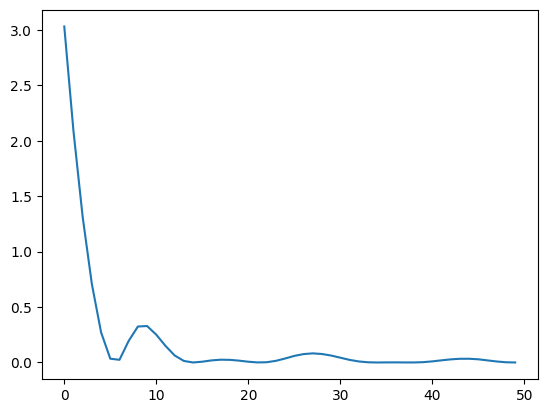

In [118]:
plt.plot(losses)

In [119]:
out_x = model(x, decode=False)
out_x.shape

TensorShape([2, 32, 2])

In [120]:
res = 30
x_c = np.linspace(-1.5, 1.5, res)
x_dot_c = np.linspace(-6., 6., res)
X, Y = np.meshgrid(x_c, x_dot_c)
coords = tf.concat([tf.stack([[X[x, y], Y[x, y]] for y in range(res)], axis=0) for x in range(res)], axis=0)
coords = tf.cast(coords, tf.float64)
coords.shape

TensorShape([900, 2])

In [121]:
dx_dt = sonode(None, coords)
dx_dt.shape

TensorShape([900, 2])

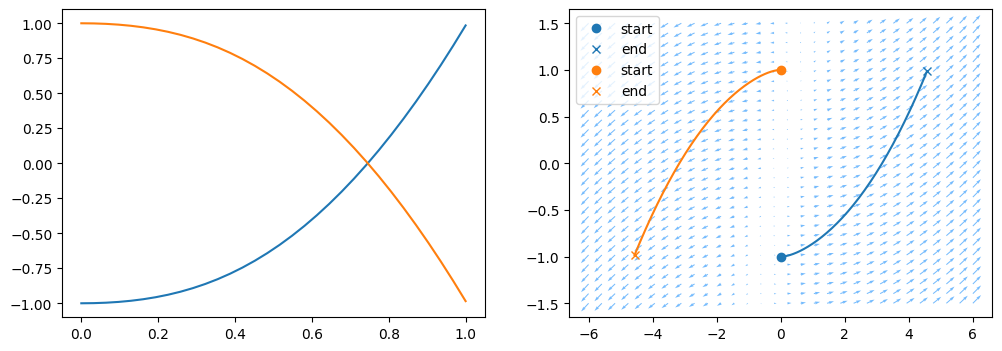

In [122]:
ax_1 = 1
ax_2 = 0
t_eval = np.linspace(0, 1, out_x.shape[1])
fig, (ax_1d, ax_2d) = plt.subplots(1, 2, figsize=(12,4))
ax_2d.quiver(coords[:, ax_1], coords[:, ax_2], dx_dt[:, ax_1], dx_dt[:, ax_2], color="xkcd:sky blue")
for i in range(2):
    ax_1d.plot(t_eval, out_x[i, :, 0])
    lines = ax_2d.plot(out_x[i, :, ax_1], out_x[i, :, ax_2])
    ax_2d.plot(out_x[i, 0, ax_1], out_x[i, 0, ax_2], 'o', color=lines[0].get_c(), label="start")
    ax_2d.plot(out_x[i, -1, ax_1], out_x[i, -1, ax_2], 'x', color=lines[0].get_c(), label="end")
plt.legend()
plt.show()